# Single Location

In [1]:
%load_ext autoreload
%autoreload 2

In [83]:
import os
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass
from typing import Callable, List

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [5]:
from models.handnet_based_model import handnet_based_model
from util.training import init_device
from util.training.dataloader import split_data_for_single_location
from util.training.losses import IoULoss
from util.training.metrics import IntersectionOverUnion, MeanPixelAccuracy

In [6]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


# 準備
---

## デバイスの初期化

In [7]:
!nvidia-smi

Tue Nov  5 13:11:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:18:00.0 Off |                  Off |
| 44%   68C    P2   205W / 300W |   5772MiB / 48682MiB |     77%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:3B:00.0 Off |                  Off |
| 50%   

In [8]:
# 使用するGPUを指定
gpu = [2]

In [9]:
seed = 42
init_device(seed, gpu)

Setting random seed: 42
Random seed set for Python, NumPy, and TensorFlow.
Detected 5 GPU(s): ['/physical_device:GPU:0', '/physical_device:GPU:1', '/physical_device:GPU:2', '/physical_device:GPU:3', '/physical_device:GPU:4']
Visible GPU devices (1): ['/physical_device:GPU:2']


## ハイパーパラメータクラスの定義

In [10]:
@dataclass
class HyperParameters:
    epochs: int
    batch_size: int
    loss_function: Callable
    metrics: List[Callable]
    optimizer: Callable

## モデルの初期化関数の定義

In [11]:
def init_model(hparam):
    model = handnet_based_model(
        input_shape = (10, 52, 2),
        num_block1 = 3,
        num_block2 = 3,
        num_residual_blocks = 14, # 残差ブロックは増やすと重くなる
    )
    
    model.compile(
        optimizer = hparam.optimizer,
        loss = hparam.loss_function,
        metrics = hparam.metrics,
    )

    return model

## コールバック準備関数の定義

In [153]:
def prepare_callbacks(hparam, log_dirpath):

    callbacks = [
        TensorBoard(log_dir=log_dirpath, histogram_freq=1),
        EarlyStopping(
            monitor='val_iou',
            mode='max',
            patience=10,
            restore_best_weights=True,
        )
    ]

    return callbacks

## モデルを訓練する関数の定義

In [85]:
def train(hparam, dataset, log_dirpath):
    print(f'log_dir = {log_dirpath}')

    # データの用意
    train_data, valid_data, test_data = dataset
    X_train, Y_train = train_data
    X_valid, Y_valid = valid_data
    X_test, Y_test = test_data

    # モデルを作成
    model = init_model(hparam)

    # モデルのフィッティング
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_valid, Y_valid),
        epochs = hparam.epochs,
        batch_size = hparam.batch_size,
        verbose = 1,
        callbacks = prepare_callbacks(hparam, log_dirpath)
    )

    # テストデータでの評価
    test_loss, *test_metric = model.evaluate(X_test, Y_test, verbose=2)
    print(f"Test Loss: {test_loss}, Test Metric: {test_metric}")

    return history, model

# モデルの訓練
---

In [86]:
def get_log_dirpath(root_log_dirpath, notebook_name):
    date = datetime.now().strftime("%Y-%m-%d")
    time = datetime.now().strftime("%H-%M-%S")
    log_dirpath = os.path.join(
        root_log_dirpath, 
        date,
        notebook_name,
        time
    )

    return log_dirpath

In [162]:
# データをロード
csi_preprocess_id = 'real_and_imag'
location = '511'
dataset = split_data_for_single_location(csi_preprocess_id, location, shuffle=True)

# ハイパーパラメータの指定
hparam = HyperParameters(
    epochs = 150,
    batch_size = 256,
    optimizer = Adam(learning_rate=0.001),
    loss_function = BinaryFocalCrossentropy(gamma=2), # BinaryCrossentropy()
    metrics = [IntersectionOverUnion(threshold=0.5), MeanPixelAccuracy()],
)

# ログディレクトリを指定
project_dirpath = Path('/tf/workspace/deformation-prediction-multi-environment')
root_log_dirpath = project_dirpath/'logs' 
notebook_name = f'tsingle_location_real_and_imag_{location}'
log_dirpath = get_log_dirpath(root_log_dirpath, notebook_name)

history, model = train(hparam, dataset, log_dirpath)

train data shuffled.
log_dir = /tf/workspace/deformation-prediction-multi-environment/logs/2024-11-05/tsingle_location_real_and_imag_511/14-31-17
Epoch 1/150
33/33 [==============================] - 58s 257ms/step - loss: 0.8041 - iou: 0.3148 - mpa: 0.7221 - val_loss: 0.8059 - val_iou: 0.2980 - val_mpa: 0.7096
Epoch 2/150
33/33 [==============================] - 7s 204ms/step - loss: 0.7955 - iou: 0.3583 - mpa: 0.7659 - val_loss: 0.7998 - val_iou: 0.3363 - val_mpa: 0.7441
Epoch 3/150
33/33 [==============================] - 6s 198ms/step - loss: 0.7947 - iou: 0.3674 - mpa: 0.7697 - val_loss: 0.7973 - val_iou: 0.3389 - val_mpa: 0.7427
Epoch 4/150
33/33 [==============================] - 6s 196ms/step - loss: 0.7943 - iou: 0.3713 - mpa: 0.7714 - val_loss: 0.7963 - val_iou: 0.3393 - val_mpa: 0.7409
Epoch 5/150
33/33 [==============================] - 6s 199ms/step - loss: 0.7940 - iou: 0.3747 - mpa: 0.7737 - val_loss: 0.7965 - val_iou: 0.3927 - val_mpa: 0.7479
Epoch 6/150
33/33 [=========

# 評価
---

In [163]:
_, valid_data, test_data = dataset
X_valid, Y_valid = valid_data
X_test, Y_test = test_data

## 各メトリックの平均値

In [164]:
results = model.evaluate(X_test, Y_test)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.04f}")

57/57 [==============================] - 2s 32ms/step - loss: 0.7947 - iou: 0.3761 - mpa: 0.7181
loss: 0.7947
iou: 0.3761
mpa: 0.7181


# 予測結果のサンプルをランダムに表示

In [165]:
from util.plot import plot_predictions

In [166]:
metrics = {'IoU': IntersectionOverUnion(threshold=0.5), 'mPA': MeanPixelAccuracy()}

57/57 [==============================] - 3s 29ms/step


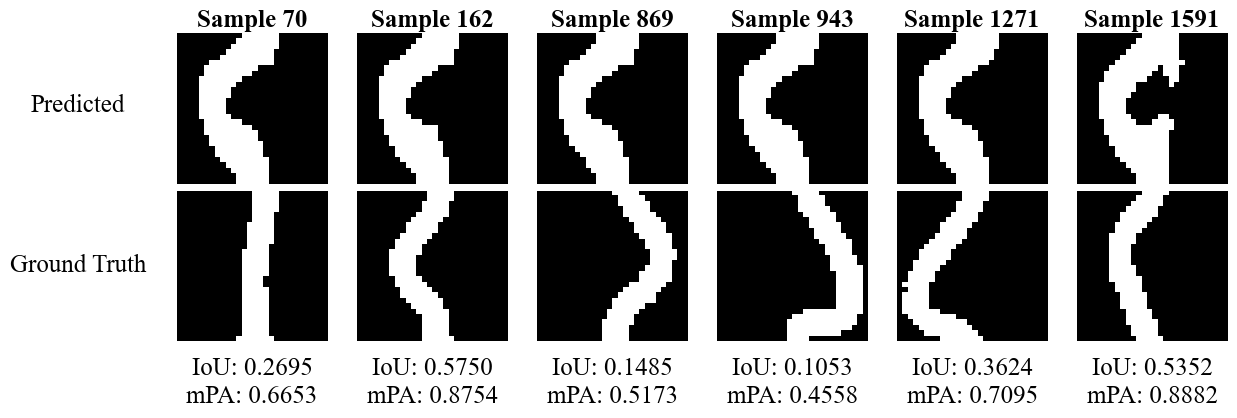

In [167]:
# 検証セット
plot_predictions(model, X_valid, Y_valid, n_samples=6, threshold=0.5, seed=42, metrics=metrics)

57/57 [==============================] - 1s 24ms/step


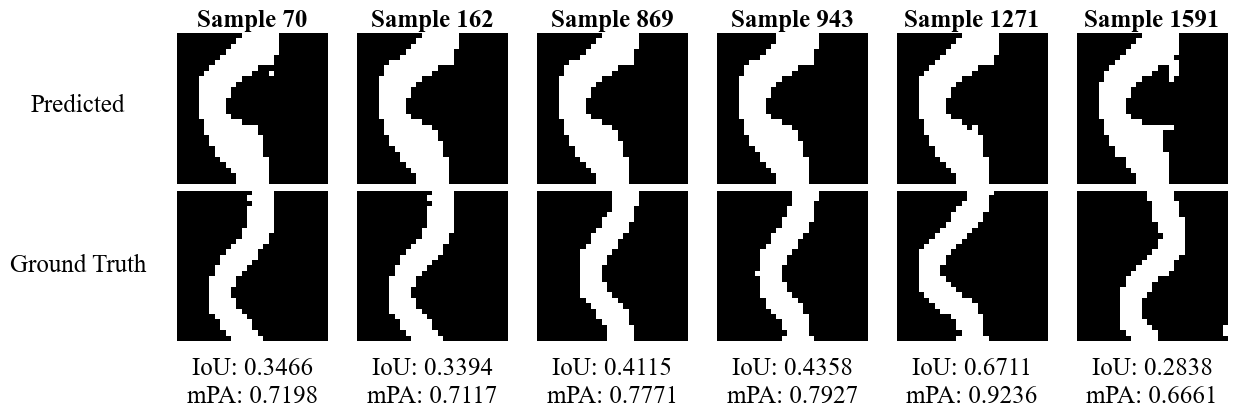

In [170]:
# テストセット
plot_predictions(model, X_test, Y_test, n_samples=6, threshold=0.5, seed=42, metrics=metrics)

57/57 [==============================] - 1s 23ms/step


(-0.5, 27.5, 27.5, -0.5)

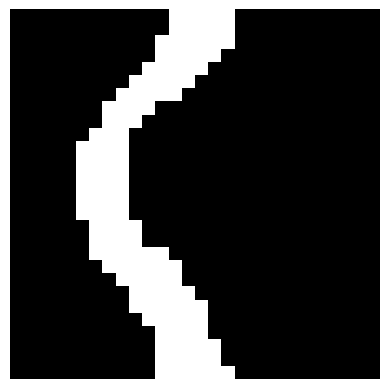

In [161]:
i = 1700
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >= 0.5).astype(np.float32)
plt.imshow(Y_pred[i], cmap='gray')
plt.axis('off')